In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as formula
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error


In [2]:
data = pd.read_csv("dataset/PRSA_Data_Aotizhongxin_20130301-20170228.csv")
data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [3]:
#drop the unwanted columns
data = data.drop(['No', 'station'], axis = 1)

In [4]:
#Checking for duplicate and null values in data

print("Are there any duplicate value in data: {}\n".format(data.duplicated().any()))
print("Total number of null values in each column: ")
data.isnull().sum()

Are there any duplicate value in data: False

Total number of null values in each column: 


year        0
month       0
day         0
hour        0
PM2.5     925
PM10      718
SO2       935
NO2      1023
CO       1776
O3       1719
TEMP       20
PRES       20
DEWP       20
RAIN       20
wd         81
WSPM       14
dtype: int64

In [5]:
#find the most appearing wind direction value 
data.wd.mode()

0    NE
Name: wd, dtype: object

In [6]:
data.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0


In [7]:
#fill the missing values with the mean of the particular column
for col in data.columns:
    if data[col].dtype in ['int64', 'float64']:
        data[col].fillna(data[col].mean(), inplace=True)
    else:
        data[col].fillna('NE', inplace = True)

print(data.isnull().any())

year     False
month    False
day      False
hour     False
PM2.5    False
PM10     False
SO2      False
NO2      False
CO       False
O3       False
TEMP     False
PRES     False
DEWP     False
RAIN     False
wd       False
WSPM     False
dtype: bool


/tmp/ipykernel_23243/1888168387.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
/tmp/ipykernel_23243/1888168387.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [8]:
# create a datetime column using the year,month,day and hour columns.
years = data['year'].values
months = data['month'].values
days = data['day'].values
hours = data['hour'].values
full_date = []

for i in range(data.shape[0]):
    date_time = str(years[i])+'-'+str(months[i])+'-'+str(days[i])+' '+str(hours[i])+':'+str(0)
    full_date.append(date_time)

dates = pd.to_datetime(full_date)
dates = pd.DataFrame(dates,columns=['date'])
data = pd.concat([dates,data],axis=1)

data.head()

,date,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,2013-03-01 00:00:00,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4
1,2013-03-01 01:00:00,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7
2,2013-03-01 02:00:00,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6
3,2013-03-01 03:00:00,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1
4,2013-03-01 04:00:00,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0


<Figure size 1200x500 with 0 Axes>

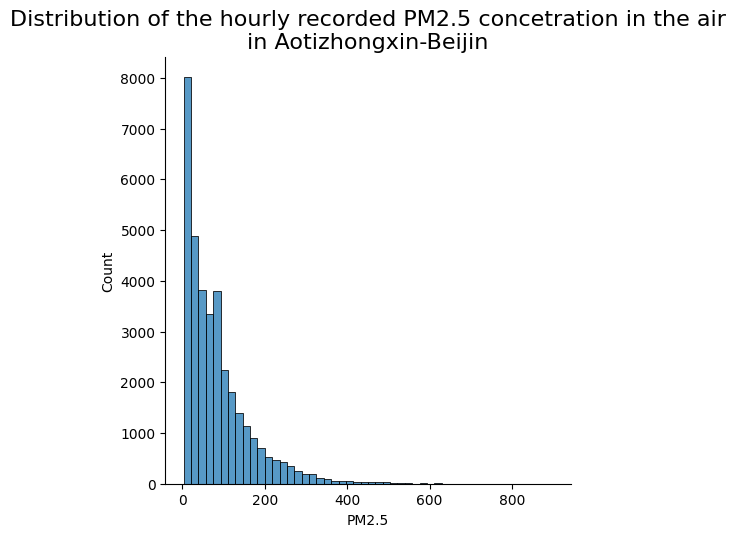

In [9]:
plt.figure(figsize=(12,5))
sns.displot(data['PM2.5'], bins=50)
plt.title('Distribution of the hourly recorded PM2.5 concetration in the air\nin Aotizhongxin-Beijin',
          fontsize=16)
plt.show()


In which month does the amount of PM2.5 contained in the air rises ?

/tmp/ipykernel_23243/2979007615.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_data.month = monthly_data.month.map(map_dict)


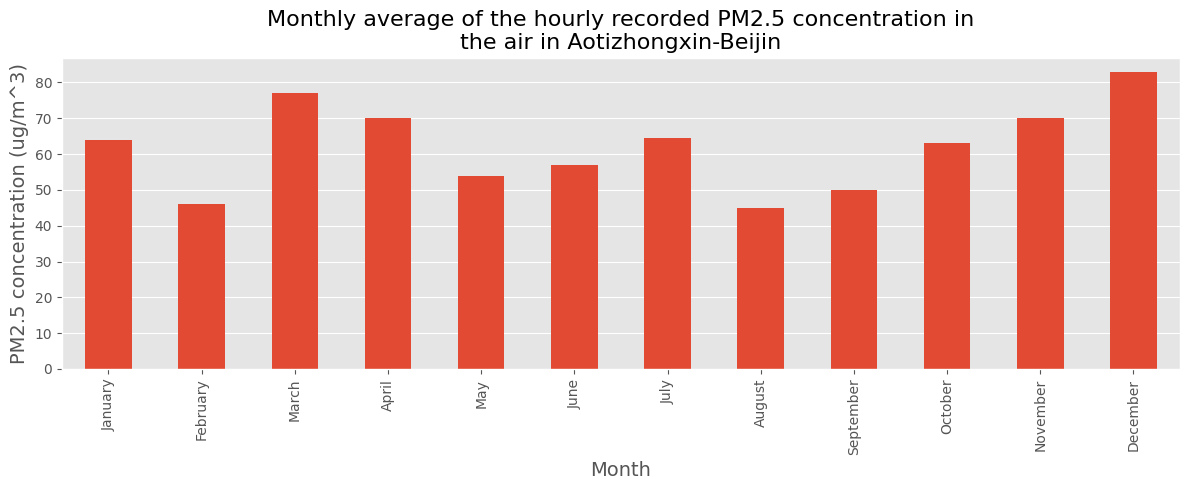

In [10]:
monthly_data = data[['month','PM2.5']]
months = ['January','February','March','April','May','June','July',
         'August','September','October','November','December']
ordered_monthdf = pd.DataFrame(months,columns=['month'])
map_dict = {}
for i,j in enumerate(months):
    map_dict.setdefault(i+1,j)

monthly_data.month = monthly_data.month.map(map_dict)
monthly_average = monthly_data.groupby('month').median()
monthly_average = pd.merge(ordered_monthdf,monthly_average,left_on='month',right_index=True)
monthly_average = np.round(monthly_average,1)
monthly_average = monthly_average.set_index('month')

# plot the data
with plt.style.context('ggplot'):
    monthly_average.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Month',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly average of the hourly recorded PM2.5 concentration in\nthe air in Aotizhongxin-Beijin',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

At what time of the day do we expect the amount of PM2.5 concentration in the air to be high ?

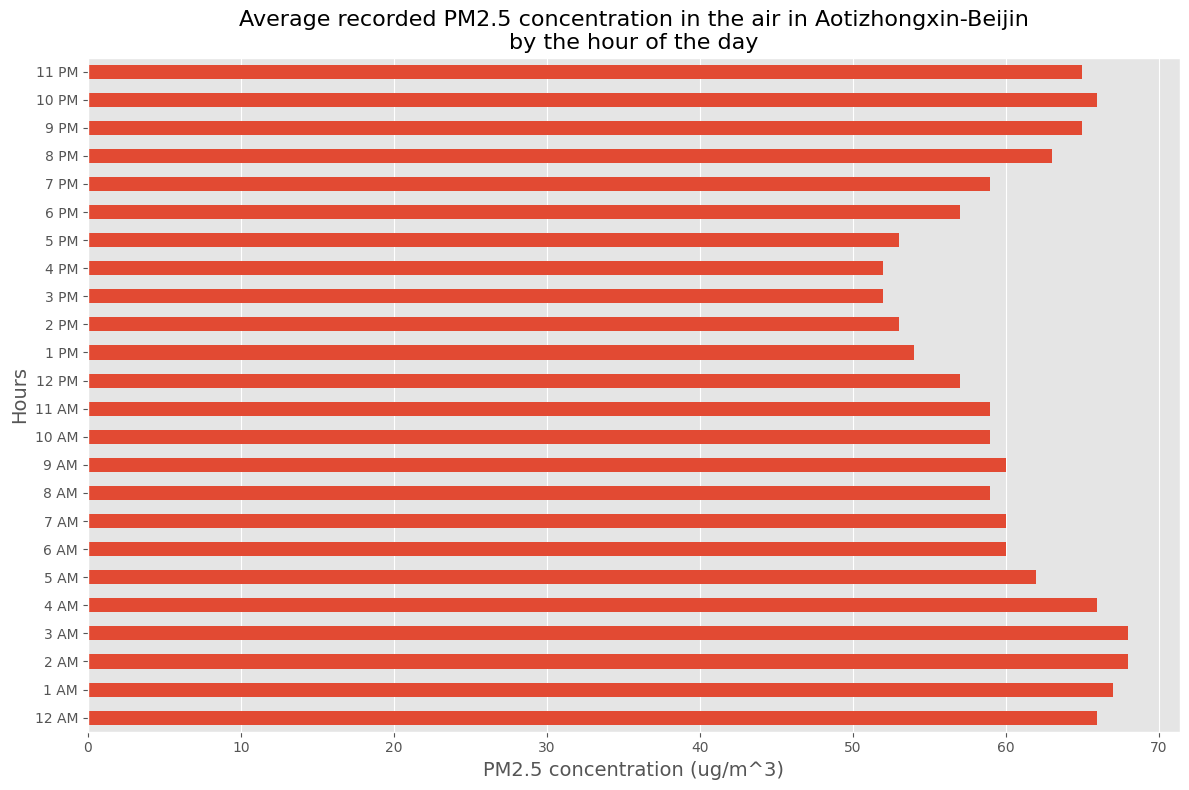

In [11]:

hourly_data = data[['hour','PM2.5']]
hrs = ['12 AM','1 AM','2 AM','3 AM','4 AM','5 AM','6 AM','7 AM','8 AM','9 AM','10 AM',
      '11 AM','12 PM','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM','7 PM',
      '8 PM','9 PM','10 PM','11 PM']
hour_dict = {}
for i,j in enumerate(hrs):
    hour_dict.setdefault(i,j)
    
hourly_data = hourly_data.groupby('hour').median().reset_index()
hourly_data.hour = hourly_data.hour.map(hour_dict)
hourly_data = hourly_data.set_index('hour')

# plot the data
with plt.style.context('ggplot'):
    hourly_data.plot(figsize=(12,8),legend=False,kind='barh',linewidth=.9)
    plt.ylabel('Hours',fontsize=14)
    plt.xlabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Average recorded PM2.5 concentration in the air in Aotizhongxin-Beijin\nby the hour of the day',fontsize=16)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In which direction does polluted air/wind mostly move ?

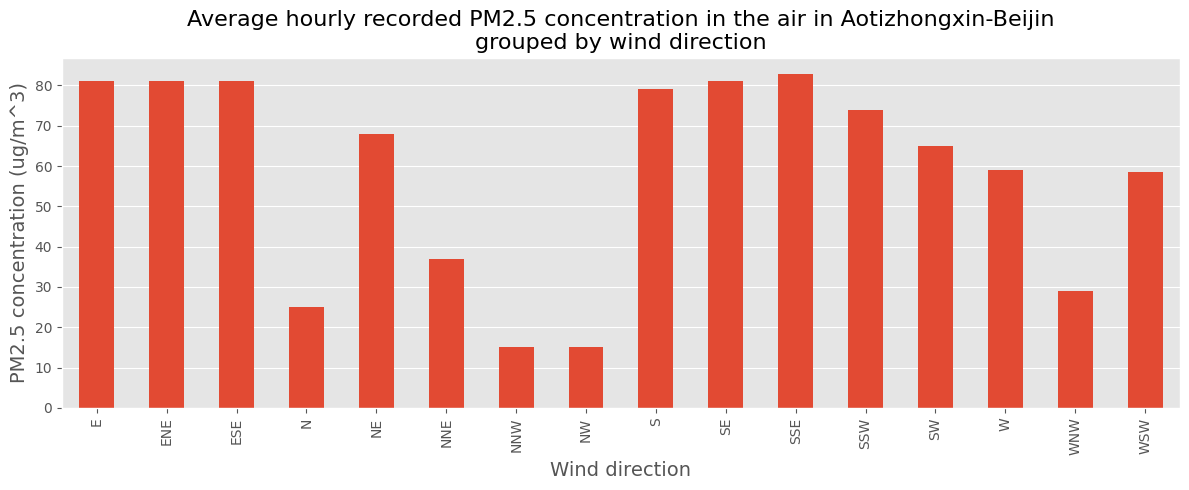

In [12]:
wind_dir = data[['wd','PM2.5']]
wind_dir = wind_dir.groupby('wd').median()

# plot the data
with plt.style.context('ggplot'):
    wind_dir.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Wind direction',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Average hourly recorded PM2.5 concentration in the air in Aotizhongxin-Beijin\ngrouped by wind direction',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

How do the other environmental factors affect the amount of PM2.5 concentration in the air ?

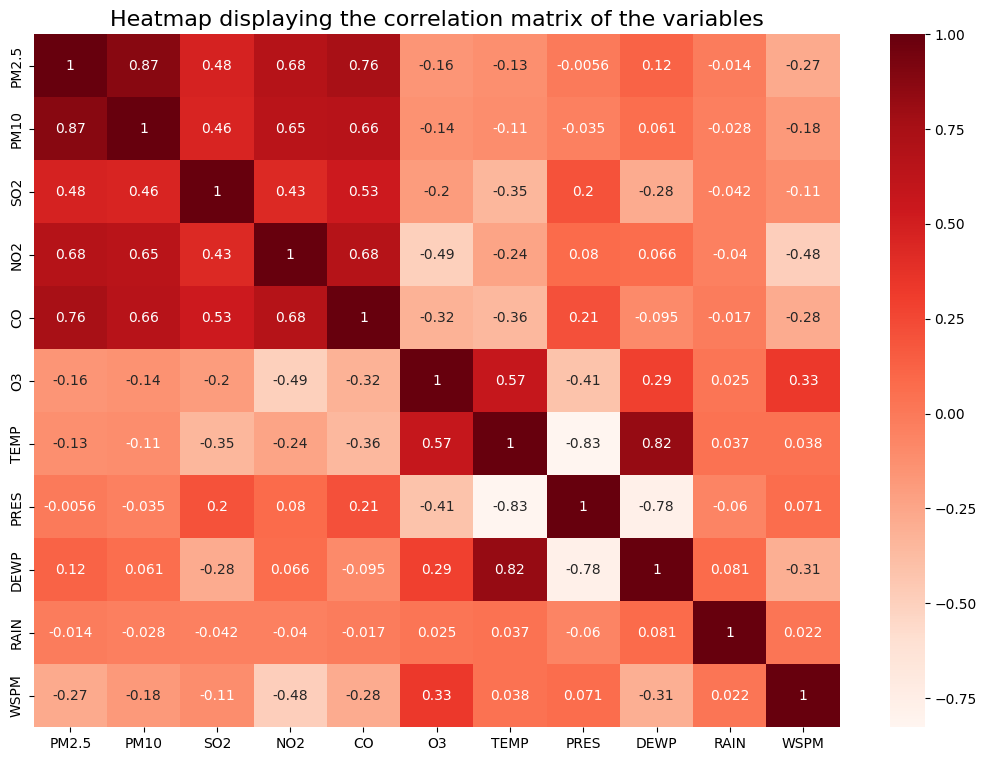

In [13]:

# let's try and visualize the relationships between the features of the data
plt.figure(figsize=(13,9))
correlation_data = data[['PM2.5', 'PM10', 'SO2', 'NO2',
                         'CO', 'O3', 'TEMP', 'PRES',
                         'DEWP', 'RAIN', 'WSPM']]
sns.heatmap(correlation_data.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the correlation matrix of the variables',fontsize=16)
plt.show()


Model Training and Evaluation

In [14]:

cols_to_drop = ['date','year','month','day','hour','wd']
newdata = data.drop(cols_to_drop,axis=1)

# calculate the variance inflation factor of each feature and detect multicollinearity
cons_data = sm.tools.add_constant(newdata)
series_before = pd.Series([variance_inflation_factor(cons_data.values,i) for i in range(cons_data.shape[1])],
                         index=cons_data.columns)
series_before

const    35340.419725
PM2.5        6.350322
PM10         4.811566
SO2          1.670510
NO2          3.320432
CO           3.159039
O3           2.250103
TEMP         8.214959
PRES         3.667310
DEWP         6.517281
RAIN         1.023639
WSPM         1.788731
dtype: float64

In [15]:
# we can see that TEMP (temperature) and DEWP (dewpoint) are highly correlated as the VIF value is 
# greater than 5. As a result, we get rid of one of those features and probably the one that has the 
# lowest correlation with the dependent variable.
newdata = newdata.drop('DEWP',axis=1)
cons_data2 = sm.tools.add_constant(newdata)
series_after = pd.Series([variance_inflation_factor(cons_data2.values,i) for i in range(cons_data2.shape[1])],
                         index=cons_data2.columns)
series_after

const    33490.920665
PM2.5        5.972024
PM10         4.704558
SO2          1.560019
NO2          3.314615
CO           3.133916
O3           2.168322
TEMP         4.559340
PRES         3.463731
RAIN         1.009170
WSPM         1.460474
dtype: float64

In [16]:
newdata.columns = ['PM2_5','PM10','SO2','NO2','CO','O3','TEMP','PRES','RAIN','WSPM']

# PM2.5 is skewed to the right so we log transform the values to normalize the distribution
newdata['PM2_5'] = np.log(newdata['PM2_5'])


#### Spliting the data

In [18]:
# we split the data into predictor variables and Outcome variable
X = newdata.drop('PM2_5',axis=1)
y = newdata['PM2_5']

# we need to scale or normalize the predictor variables since they are not on the same
# scale and some of their distributions are skewed.
X_scaled =  preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.dropna(inplace=True)
# print the scaled predictor variables.
X_scaled.head()

,PM10,SO2,NO2,CO,O3,TEMP,PRES,RAIN,WSPM
0,-1.125409,-0.594053,-1.430285,-0.809141,0.365570,-1.253510,1.072316,-0.074107,2.235814
1,-1.082965,-0.594053,-1.430285,-0.809141,0.365570,-1.288611,1.091545,-0.074107,2.485022
2,-1.093576,-0.549641,-1.348251,-0.809141,0.294746,-1.288611,1.120388,-0.074107,3.232647
3,-1.104187,-0.283168,-1.320906,-0.809141,0.277040,-1.314937,1.216533,-0.074107,1.155913
4,-1.136020,-0.238756,-1.293562,-0.809141,0.277040,-1.367589,1.283835,-0.074107,0.242150


#### LinearRegression

In [19]:

# we now split out data into train and test data
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=.2,random_state=0)

# instantiate the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)   # fit the model

LinearRegression()

In [20]:
# we now score the model
print('Score on train data: {}\n'.format(lin_model.score(X_train,y_train)))
print('Score on test data: {}'.format(lin_model.score(X_test,y_test)))

Score on train data: 0.7116905619118639

Score on test data: 0.7138206964831479


In [21]:
prediction = lin_model.predict(X_test)
mse = mean_squared_error(y_test,prediction)
lin_accuracy = r2_score(y_test,prediction)

print('Mean Squared Error: {}\n'.format(mse))
print('Overall model accuracy: {}'.format(lin_accuracy))

Mean Squared Error: 0.33844199580898776

Overall model accuracy: 0.7138206964831479


#### DevisionTreeRegressor

In [22]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt_train_results=dt.predict(X_train)
dt_test_results=dt.predict(X_test)
#print("Training Results:")
#print("MSE:", mean_squared_error(dt_train_results, y_train))
#print("R2 Score:",r2_score(dt_train_results, y_train))
#print("Testing Results:")
#print("MSE:", mean_squared_error(dt_test_results, y_test))
#print("R2 Score:", r2_score(dt_test_results, y_test))



In [23]:
# we now score the model
print('Score on train data: {}\n'.format(dt.score(X_train,y_train)))
print('Score on test data: {}'.format(dt.score(X_test,y_test)))

Score on train data: 1.0

Score on test data: 0.8185999928213976


In [24]:
prediction = dt.predict(X_test)
mse = mean_squared_error(y_test,prediction)
dt_accuracy = r2_score(y_test,prediction)

print('Mean Squared Error: {}\n'.format(mse))
print('Overall model accuracy: {}'.format(dt_accuracy))

Mean Squared Error: 0.21452767448529225

Overall model accuracy: 0.8185999928213976


#### SVR


In [25]:
from sklearn.svm import SVR
svr=SVR()
svr.fit(X_train, y_train)
svr_train_results=svr.predict(X_train)
svr_test_results=svr.predict(X_test)

In [26]:
# we now score the model
print('Score on train data: {}\n'.format(svr.score(X_train,y_train)))
print('Score on test data: {}'.format(svr.score(X_test,y_test)))

Score on train data: 0.88854143804943

Score on test data: 0.8868867718665439


In [27]:
prediction = svr.predict(X_test)
mse = mean_squared_error(y_test,prediction)
svr_accuracy = r2_score(y_test,prediction)

print('Mean Squared Error: {}\n'.format(mse))
print('Overall model accuracy: {}'.format(svr_accuracy))

Mean Squared Error: 0.13377021402817804

Overall model accuracy: 0.8868867718665439


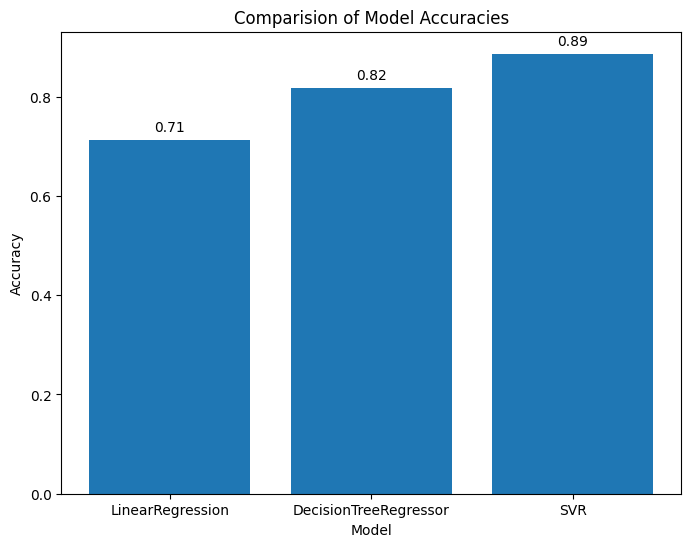

In [28]:
fig, ax = plt.subplots(figsize = (8, 6))

model_names = ['LinearRegression', 'DecisionTreeRegressor', 'SVR']
model_accuracies = [lin_accuracy, dt_accuracy, svr_accuracy]

ax.bar(model_names, model_accuracies)

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Comparision of Model Accuracies')

for i, accuracy in enumerate(model_accuracies):
    ax.text(i, accuracy + 0.01, f"{accuracy:.2f}", ha='center', va='bottom')

plt.show()